In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
train_path = 'Train/'
test_path = 'Test/'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = (224,224,3)

In [5]:
train_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 subset='training')

val_data = train_generator.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 subset='validation')

test_generator  = ImageDataGenerator(rescale=1./255)
test_data = test_generator.flow_from_directory(test_path,
                                                 target_size=(224, 224),
                                                 color_mode="rgb",
                                                 class_mode="categorical",shuffle=False,
                                                 batch_size=BATCH_SIZE)

Found 42740 images belonging to 3 classes.
Found 10684 images belonging to 3 classes.
Found 16238 images belonging to 3 classes.


<h2>Model Architecture</h2>

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=IMAGE_SIZE))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4096, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

for layer in baseModel.layers:
    layer.trainable = False

model = Model(inputs=baseModel.input, outputs=headModel)

opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
early_stop = EarlyStopping(patience=2,monitor='val_loss')

<h2>Training</h2>

In [10]:
results = model.fit_generator(train_data,epochs=20,
                              validation_data=val_data,
                             callbacks=[early_stop])

Epoch 1/20
668/668 [==============================] - 17434s 26s/step - loss: 0.3440 - accuracy: 0.9339 - val_loss: 0.1715 - val_accuracy: 0.9419
Epoch 2/20
668/668 [==============================] - 14347s 21s/step - loss: 0.1723 - accuracy: 0.9465 - val_loss: 0.1531 - val_accuracy: 0.9574
Epoch 3/20
668/668 [==============================] - 44705s 67s/step - loss: 0.1578 - accuracy: 0.9507 - val_loss: 0.1540 - val_accuracy: 0.9611
Epoch 4/20
668/668 [==============================] - 10064s 15s/step - loss: 0.1361 - accuracy: 0.9572 - val_loss: 0.1604 - val_accuracy: 0.9530


<h2>Model evaluation</h2>

<AxesSubplot:>

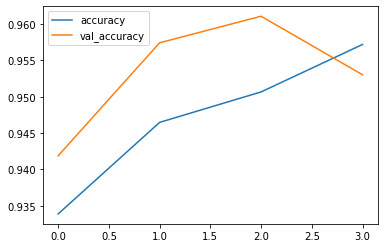

In [11]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

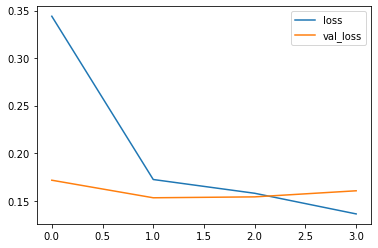

In [12]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [13]:
test_pred = model.predict_generator(test_data)

In [14]:
pred_class = [np.argmax(x) for x in test_pred]

In [15]:
test_data.class_indices

{'background': 0, 'crop': 1, 'weed': 2}

In [16]:
true_class = test_data.classes

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
print(classification_report(true_class,pred_class))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10760
           1       0.93      0.96      0.95      3147
           2       0.98      0.83      0.90      2331

    accuracy                           0.96     16238
   macro avg       0.96      0.93      0.94     16238
weighted avg       0.96      0.96      0.96     16238



In [ ]:
cm = pd.DataFrame(data=confusion_matrix(true_class, pred_class, labels=[0,1,2]),index=["Actual Background", "Actual Crop"."Actual Weed"],
columns=["Predicted Background", "Predicted Crop" , "Predicted Weed"])
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,4))
plt.rcParams.update({'font.size': 10})
sns.heatmap(cm,annot=True,fmt="d",ax=ax)

<AxesSubplot:>

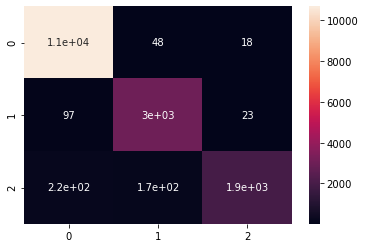

In [19]:
# sns.heatmap(confusion_matrix(true_class,pred_class),annot=True)

<h2>Predict on some test images</h2>

In [20]:
mapping_class = test_data.class_indices

In [21]:
mapping_class = dict([(value, key) for key, value in mapping_class.items()]) 

<h2>Prediction on Batch</h2>

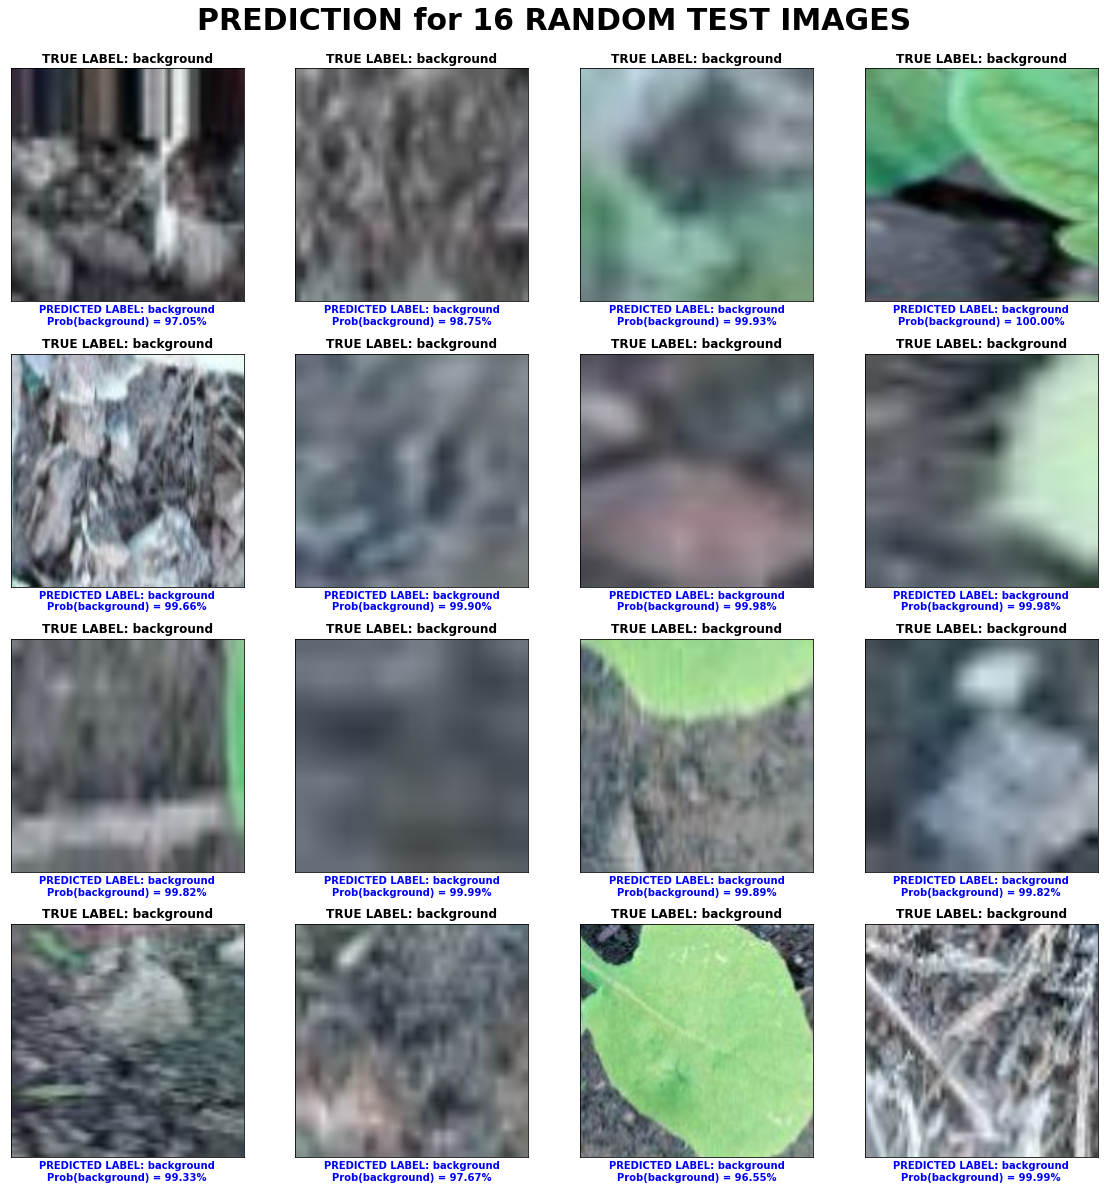

In [22]:
images, labels = next(iter(test_data))
images = images.reshape(64, 224,224,3)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images[:16], labels[:16]):
    ax.imshow(img)
    true_label = mapping_class[np.argmax(label)]
    
    pred_prob = model.predict(img.reshape(1, 224,224, 3))
    pred_label = mapping_class[np.argmax(pred_prob)]
    
    prob_class = np.max(pred_prob) * 100
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 12)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 10,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("PREDICTION for 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

<h2>Missclassified Images</h2>

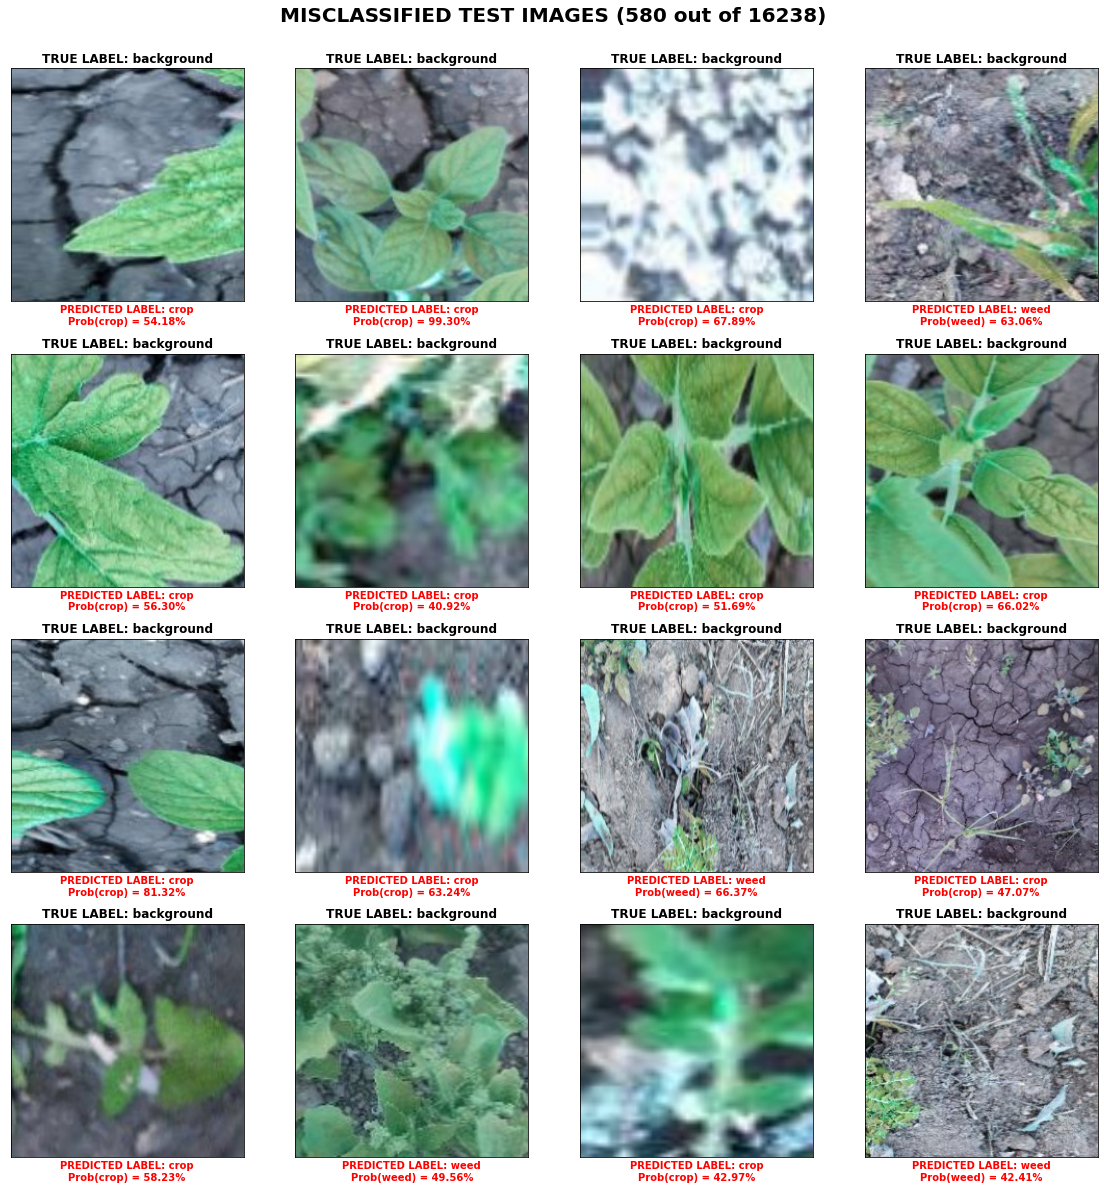

In [23]:
misclassify_pred = np.nonzero(true_class != pred_class)[0]
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_data[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE))
    
    true_label = mapping_class[np.argmax(label)]
    
    pred_prob = model.predict(img.reshape(1, 224,224, 3))
    pred_label = mapping_class[np.argmax(pred_prob)]
    
    prob_class = np.max(pred_prob)*100
    
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 12)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 10,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

<h2>Saving model</h2>

In [24]:
model.save('RCNN_crop_weed_classification_model.h5')
 